Calculate the light curves of TNO occultations based on object size, distance, and apparent stellar size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn
from scipy.integrate import dblquad
import scipy.interpolate
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# Per Eq. 11 in Rocques & Moncuquet 2000
def lommel_u(n, x, y):
    '''Lommel function U_n(x, y) for x <= y.

    Parameters:
    ----------
    n : int
        Order of the Lommel function.
    x : float
        First argument of the Lommel function. Must be less than or equal to y.
    y : float
        Second argument of the Lommel function.
    '''
    if x > y:
        raise ValueError("x must be less than or equal to y.")
    sum_result = 0
    for k in range(50):  # Summation to 50 terms should be accurate enough
        term = ((-1)**k * (x / y)**(n + 2 * k) * jn(n + 2 * k, np.pi * x * y))
        sum_result += term
    return sum_result

# Per Eqs. 9 and 10 in Rocques & Moncuquet 2000
def occultation_intensity(r, rho):
    '''Intensity profile for a TNO occultation at distance r from the shadow center.
    
    Parameters:
    ----------
    r : float
        Distance from the center of the shadow in Fresnel units.
    rho : float
        Radius of the TNO in Fresnel units.'''
    if r >= rho:
        # Outside the shadow (Equation 9)
        u1 = lommel_u(1, rho, r)
        u2 = lommel_u(2, rho, r)
        term1 = 1 + u1**2 + u2**2
        term2 = -2 * u1 * np.sin(np.pi / 2 * (r**2 + rho**2))
        term3 = 2 * u2 * np.cos(np.pi / 2 * (r**2 + rho**2))
        return term1 + term2 + term3
    else:
        # Inside the shadow (Equation 10)
        u0 = lommel_u(0, r, rho)
        u1 = lommel_u(1, r, rho)
        return u0**2 + u1**2

In [3]:
# Create lookup table for the intensity profile. Run this once then create a
# scipy interpolator object to use in the main code.
num_points = 400
r_points = np.linspace(0, 20, num_points)
rho_points = np.linspace(0.01, 20, num_points)
lut_array = np.zeros((num_points ** 2, 3))
for i, r in enumerate(r_points):
    for j, rho in enumerate(rho_points):
        lut_array[i * num_points + j] = [r, rho, occultation_intensity(r, rho)]

In [4]:
interpolator = scipy.interpolate.CloughTocher2DInterpolator(lut_array[:, :2], lut_array[:, 2])

In [5]:
# See whether it's faster to interpolate from lookup table or calculate directly
import time
grid_x, grid_y = np.mgrid[0:10:100j, 0.01:10:100j]
t0 = time.time()
result1 = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        result1[i, j] = occultation_intensity(grid_x[i, j], grid_y[i, j])
t1 = time.time()
result2 = interpolator((grid_x, grid_y))
t2 = time.time()
print("Direct calculation took", t1 - t0, "seconds.")
print("Interpolation took", t2 - t1, "seconds.")

Direct calculation took 6.770097970962524 seconds.
Interpolation took 0.704556941986084 seconds.


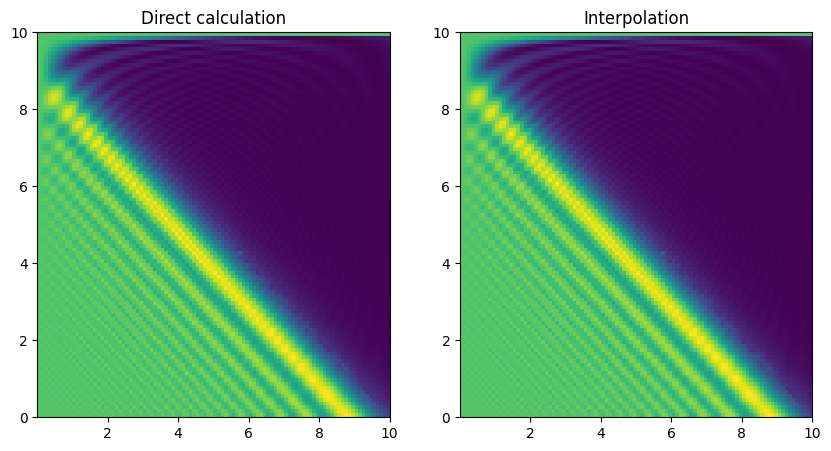

In [6]:
# Check that the interpolated result is still accurate
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(result1, extent=(0.01, 10, 0, 10), aspect='auto')
ax[0].set_title("Direct calculation")
ax[1].imshow(result1, extent=(0.01, 10, 0, 10), aspect='auto')
ax[1].set_title("Interpolation")
plt.show()

In [7]:
# Per Eqs. 12 in Rocques & Moncuquet 2000
def intensity_with_stellar_disk(r, R_TNO, R_star, n_steps=50):
    '''Intensity profile for a TNO occultation of a star with projected radius R_star.

    Parameters:
    ----------
    r : float
        Distance from the center of the shadow in Fresnel units.
    R_TNO : float
        Radius of the TNO in Fresnel units.
    R_star : float
        Projected radius of the star at the TNO distance, in Fresnel units.
    n_steps : int (default 50)
        Number of steps to use in each variable of the 2D numerical integration.
    '''
    if R_star == 0:
        return occultation_intensity(r, R_TNO)
    s_vals = np.linspace(0, R_star, n_steps)
    theta_vals = np.linspace(0, np.pi, n_steps)
    distance_vals = np.zeros(n_steps ** 2)
    s_vals_long = np.zeros(n_steps ** 2)
    for i in range(n_steps):
        for j in range(n_steps):
            s = s_vals[i]
            theta = theta_vals[j]
            distance = np.sqrt(r**2 + s**2 + 2 * r * s * np.cos(theta))
            distance_vals[i * n_steps + j] = distance
            s_vals_long[i * n_steps + j] = s
    grid_x, grid_y = np.meshgrid(distance_vals, R_TNO)
    integrand_vals = interpolator((grid_x, grid_y))
    integral_result = np.sum(integrand_vals * s_vals_long)
    normalization_factor = (2 / (np.pi * R_star**2)) * (np.pi / n_steps) * (R_star / n_steps)
    return normalization_factor * integral_result

# Compute intensity profiles for various TNO and projected star radii
r_list = np.linspace(0, 15, 250)
r_star_list = [0.1, 1, 5]
r_tno_list = [0.1, 1, 10]
intensities = np.zeros((len(r_tno_list), len(r_star_list), len(r_list)))
for i, r_tno in enumerate(r_tno_list):
    for j, r_star in enumerate(r_star_list):
        for k, r in enumerate(r_list):
            intensities[i, j, k] = intensity_with_stellar_disk(r, r_tno, r_star)

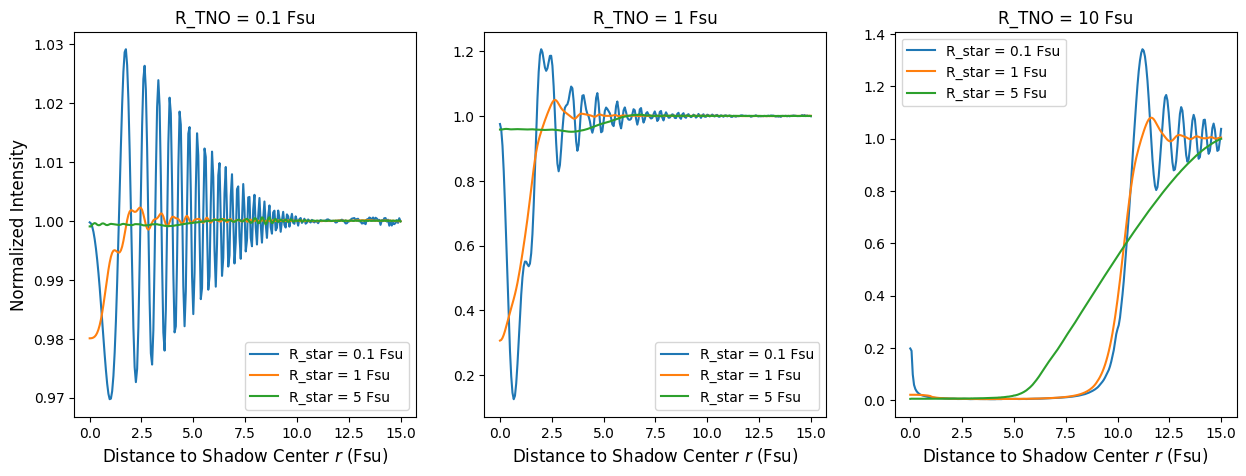

In [8]:
# Create three axes, each with a different r_tno and plotting the intensity profiles for all 5 r_star values
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
# Make all axis labels and grid labels
plt.rcParams.update({'axes.labelsize': 'large'})
plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    for j in range(3):
        ax[i].plot(r_list, intensities[i, j], label=f"R_star = {r_star_list[j]} Fsu")
    ax[i].set_xlabel(r'Distance to Shadow Center $r$ (Fsu)')
    ax[i].set_title(f'R_TNO = {r_tno_list[i]} Fsu')
    ax[i].legend(loc='lower right')

ax[0].set_ylabel('Normalized Intensity')
plt.legend()
plt.show()

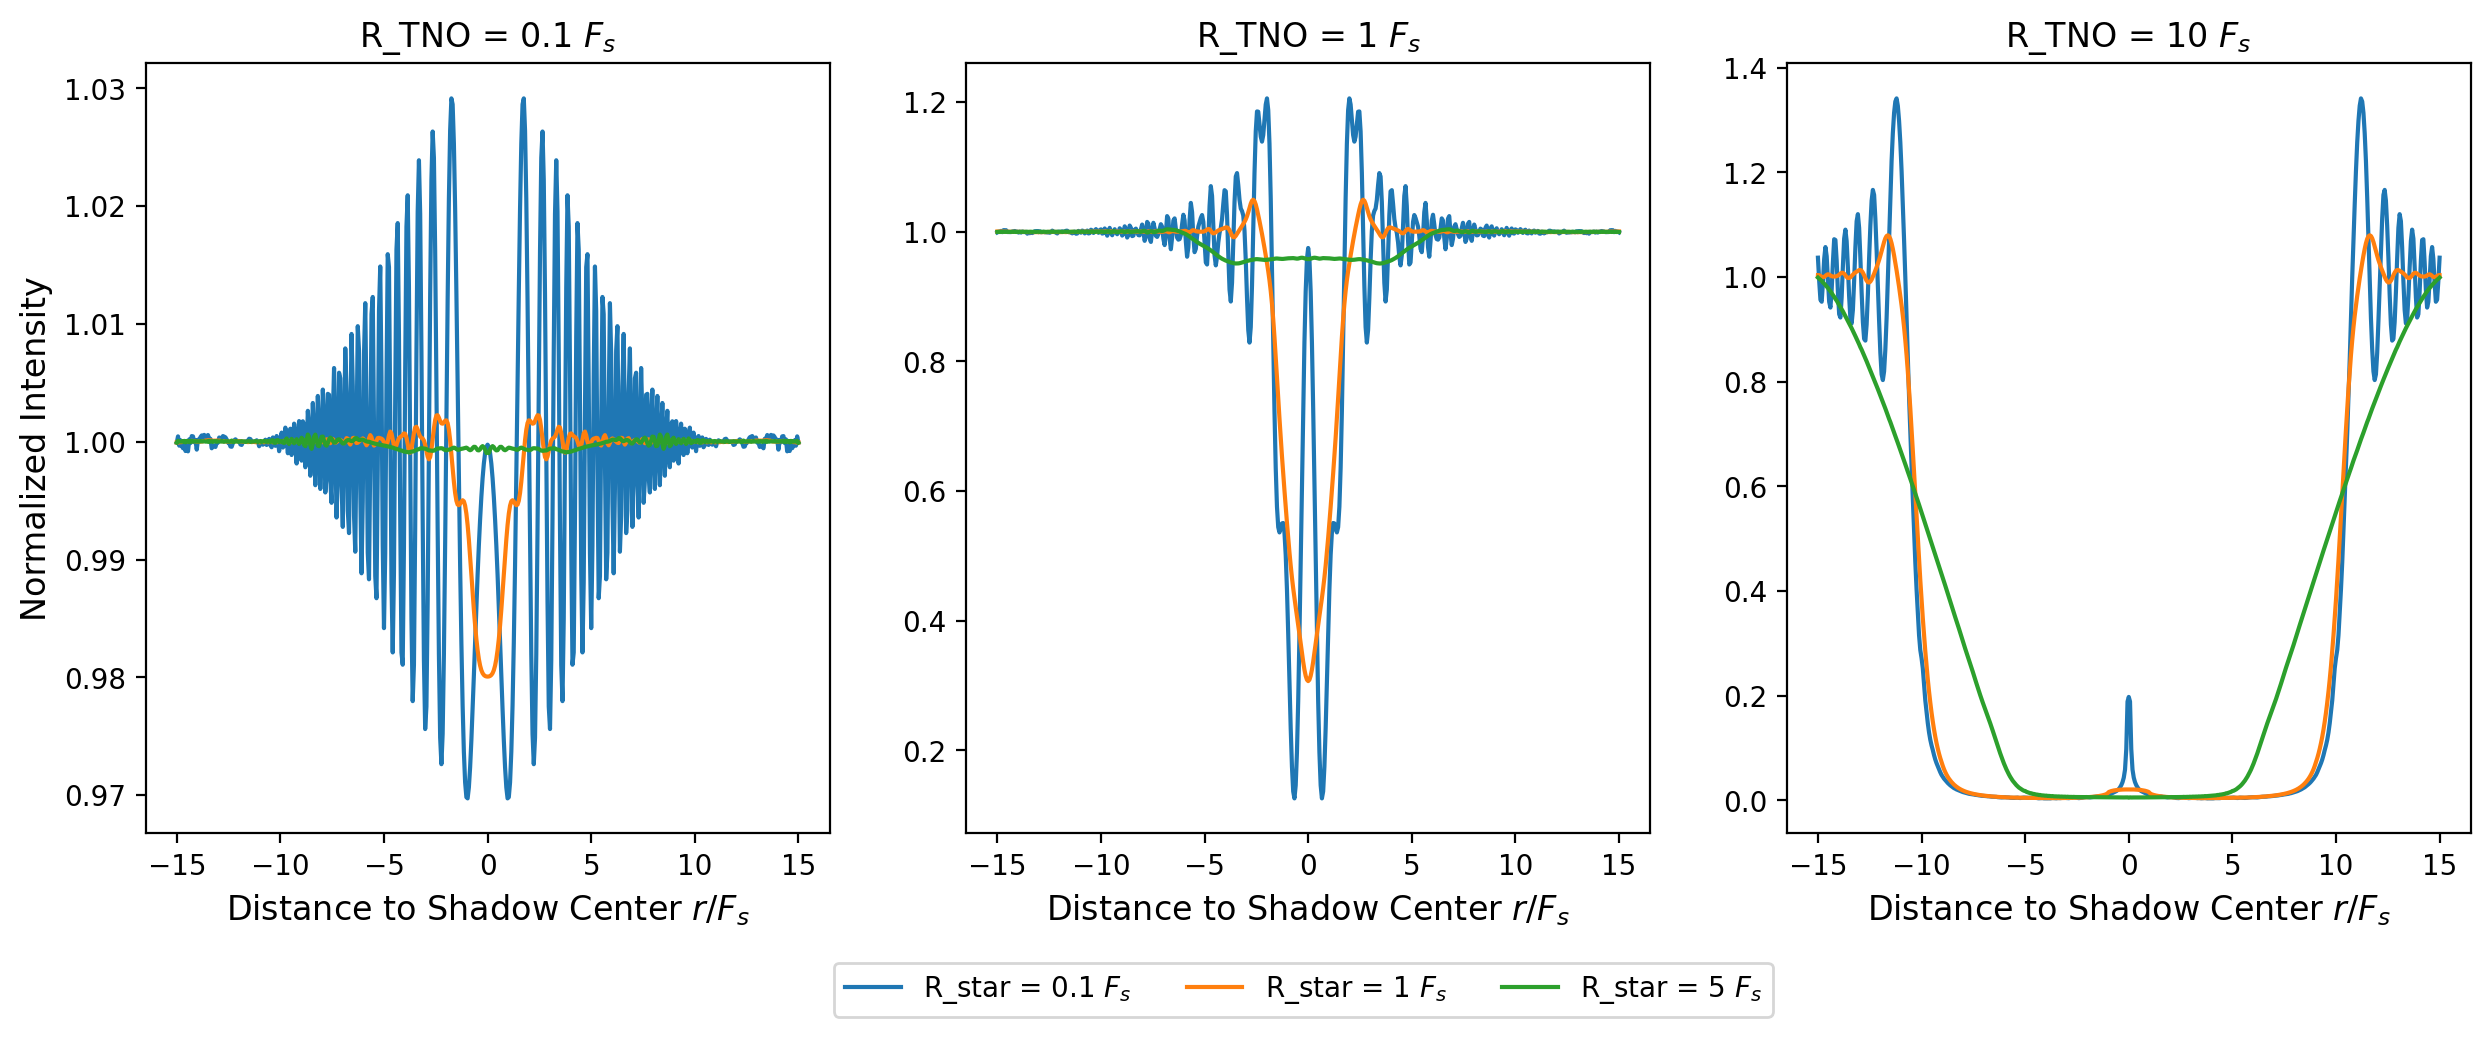

In [9]:
%matplotlib inline
# set dpi 200
plt.rcParams['figure.dpi'] = 200
# Reflect the plots over x=0 to show symmetry
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    for j in range(3):
        r_list_both = np.concatenate((-r_list[::-1], r_list))
        intensities_both = np.concatenate((intensities[i, j][::-1], intensities[i, j]))
        ax[i].plot(r_list_both, intensities_both, label=f"R_star = {r_star_list[j]}" + r' $F_s$')
    ax[i].set_xlabel(r'Distance to Shadow Center $r/F_s$')
    ax[i].set_title(f'R_TNO = {r_tno_list[i]} $F_s$')
    # ax[i].legend(loc='upper right')
# Put legend below the plots
ax[0].set_ylabel('Normalized Intensity')
ax[0].legend(loc='upper right', bbox_to_anchor=(2.4, -0.15), ncol=3)
plt.show()

In [10]:
def tno_occult_lightcurve(r_TNO, theta_star, d_TNO=40, wavelength=500,
                          omega=0, y=0, sampling_rate=10, n_steps=50,
                          smoothing_points=10):
    '''Create a synthetic light curve for a TNO occultation of a star.
    
    Parameters:
    ----------
    R_TNO : float
        Radius of the TNO in km.
    theta_star : float
        Angular radius of the star, in milliarcesconds.
    d_TNO : float (default 40)
        Distance from the Earth to the TNO in AU.
    wavelength : float (default 500)
        Wavelength of observation in nm.
    omega : float (default 0)
        Angle between solar opposition and the TNO line of sight, in degrees.
    y : float (default 0)
        Minimum distance from the star line of sight to the TNO center, in km.
    sampling_rate : int (default 10)
        Temporal sampling rate of the light curve, in Hz.
    n_steps : int (default 50)

    Returns:
    ---------
    times : array
        Array of times in seconds.
    intensities : array
        Array of normalized intensities.
    '''

    # Calculate Fresnel scale, in km
    fsu = np.sqrt(wavelength * 1e-12 * d_TNO * 1.496e8 / 2)
    # Convert TNO and star sizes to Fresnel scale units
    R_TNO_fsu = r_TNO / fsu
    R_star_fsu = theta_star / 1000 / 3600 / 180 * np.pi * d_TNO * 1.496e8 / fsu
    y_fsu = y / fsu
    if R_star_fsu + np.sqrt(y_fsu **2 + R_TNO_fsu ** 2) > 15:
        raise ValueError("System size too large--keep in under 15 Fsu.")

    # Calculate the velocity of the TNO in the sky plane, in fsu/s
    v_earth = 29.8 / fsu
    v_object = v_earth * (np.cos(omega * np.pi / 180) - np.sqrt(1 / d_TNO))
    # Time it takes for r to go from -15 to 15 fsu
    duration = 30 / v_object
    t_spacing = 1 / sampling_rate
    t_points = np.arange(0, duration, t_spacing)
    x_points = -15 + v_object * t_points
    r_points = np.sqrt(x_points**2 + y_fsu**2)
    intensity_points = np.zeros_like(t_points)
    for i, t in enumerate(t_points):
        t_subpoints = np.linspace(t - t_spacing / 2, t + t_spacing / 2, smoothing_points)
        x_subpoints = -15 + v_object * t_subpoints
        r_subpoints = np.sqrt(x_subpoints**2 + y_fsu**2)
        for j in range(smoothing_points):
            intensity_points[i] += intensity_with_stellar_disk(r_subpoints[j], R_TNO_fsu, R_star_fsu, n_steps=n_steps)
        intensity_points[i] /= smoothing_points
    result_dict = {'r_star_fsu': R_star_fsu, 'r_tno_fsu': R_TNO_fsu, 'y_fsu': y_fsu, 'times': t_points,
                   'r_points': r_points, 'intensities': intensity_points}
    return result_dict


0.15957672558078229 0.0 0.0


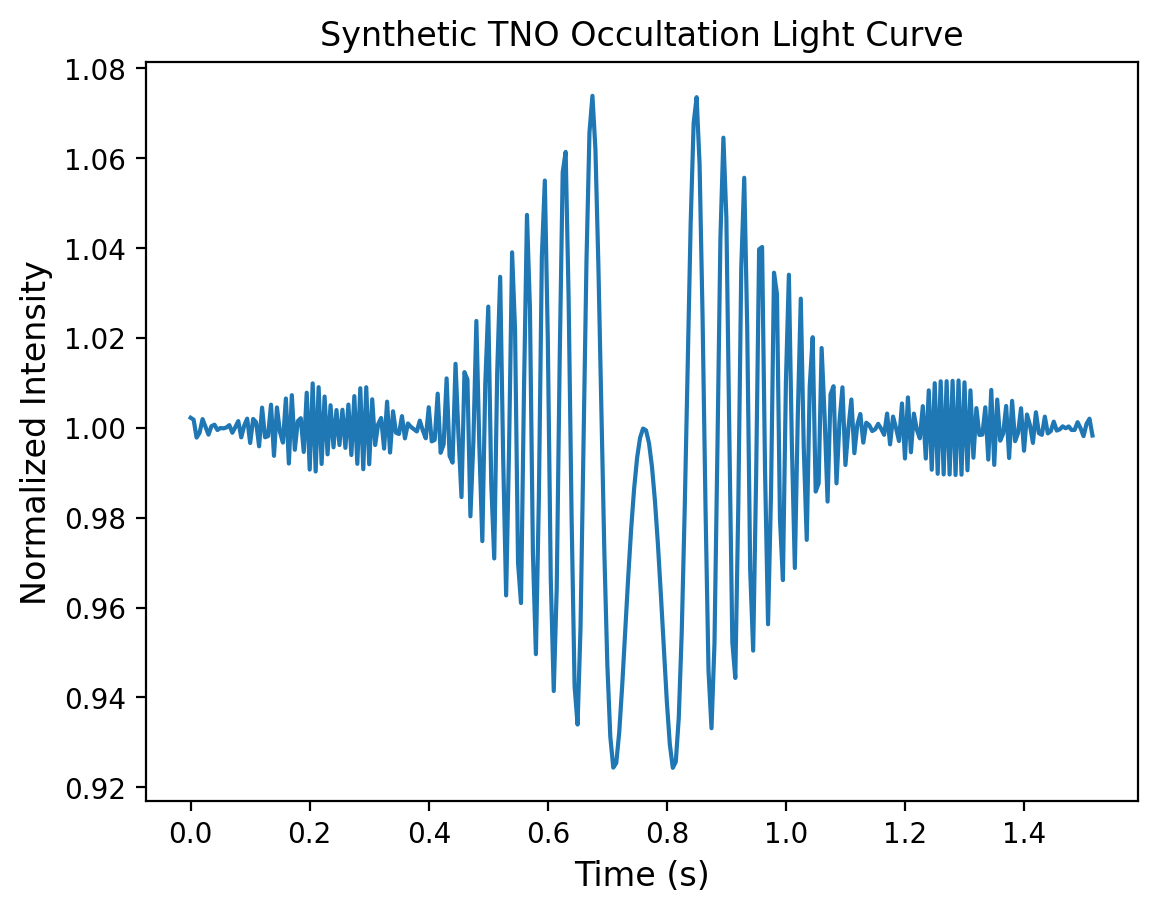

In [11]:
%matplotlib inline
lightcurve_dict = tno_occult_lightcurve(r_TNO=0.2, theta_star=0, d_TNO=35, omega=0, wavelength=600, y=0, sampling_rate=200, n_steps=50, smoothing_points=1)
print(lightcurve_dict['r_tno_fsu'], lightcurve_dict['r_star_fsu'], lightcurve_dict['y_fsu'])
plt.plot(lightcurve_dict['times'], lightcurve_dict['intensities'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Intensity')
plt.title('Synthetic TNO Occultation Light Curve')
plt.show()

In [18]:
from matplotlib.widgets import Slider
%matplotlib
# Create figure
fig, ax = plt.subplots(figsize=(12, 6))
# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Set circle sizes (not to scale, just visually proportional)
earth_radius = 0.5  # Earth size (arbitrary units)
TNO_radius = 0.2  # TNO size (smaller than Earth)
star_radius = 2.0  # Star size (larger than Earth)

# Define positions (not to scale, just visually clear)
earth_position = (2, 0)
TNO_initial_position = (8, 2)  # Start TNO below the screen
star_position = (30, 0)

# Plot the Earth (blue circle)
earth = plt.Circle(earth_position, earth_radius, color='blue', label='Earth')
# Plot the star (yellow circle)
star = plt.Circle(star_position, star_radius, color='orange', label='Star')
# Add Earth and Star to the plot
ax.add_artist(earth)
ax.add_artist(star)

# Add labels for the objects
ax.text(earth_position[0], 4, 'Earth', color='blue', fontsize=12, ha='center')
ax.text(TNO_initial_position[0], 4, 'TNO', color='black', fontsize=12, ha='center')
ax.text(star_position[0], 4, 'Star', color='orange', fontsize=12, ha='center')

# Draw lines to show the angle subtended by the star from Earth's point of view
ax.plot([earth_position[0] + earth_radius, star_position[0]], [earth_position[1], star_radius], color='orange', linestyle='--')
ax.plot([earth_position[0] + earth_radius, star_position[0]], [earth_position[1], -star_radius], color='orange', linestyle='--')

# Add distance and TNO size labels
# Add lines to show the distance between the Earth and the TNO
ax.plot([earth_position[0] + earth_radius, TNO_initial_position[0]], [-3,-3], color='black')
# Vertical lines to make it look like a ruler
ax.plot([earth_position[0] + earth_radius, earth_position[0] + earth_radius], [-2.75, -3.25], color='black')
ax.plot([TNO_initial_position[0], TNO_initial_position[0]], [-2.75, -3.25], color='black')
ax.text((earth_position[0] + earth_radius + TNO_initial_position[0]) / 2, -2.5, r'$D$', color='black', fontsize=12, ha='center')

# Remove axes and grid for a cleaner visual
ax.set_xlim(0, 35)
ax.set_ylim(-6, 6)
ax.set_aspect('equal')
ax.axis('off')

# Initialize the TNO (black circle)
tno = plt.Circle(TNO_initial_position, TNO_radius, color='black', label='TNO')
ax.add_artist(tno)

# Make a horizontal slider to control the TNO x position
ax_x = fig.add_axes([0.25, 0.1, 0.65, 0.03])
x_slider = Slider(
    ax=ax_x,
    label='TNO x',
    valmin=earth_position[0] + earth_radius,
    valmax=25,
    valinit=TNO_initial_position[0],
)
# Make a vertical slider to control the TNO y position
ax_y = fig.add_axes([0.1, 0.25, 0.03, 0.65])
y_slider = Slider(
    ax=ax_y,
    label='TNO y',
    valmin=-2,
    valmax=2,
    valinit=TNO_initial_position[1],
    orientation='vertical'
)

# Lines representing the Fresnel scale
fresnel_scale = np.sqrt(x_slider.val - earth_position[0] - earth_radius) / 2
ax.plot([TNO_initial_position[0], TNO_initial_position[0]], [-fresnel_scale / 2 + y_slider.val, fresnel_scale / 2 + y_slider.val], color='black')
# Label the line
ax.text(TNO_initial_position[0], y_slider.val + fresnel_scale / 2 + 0.4, r'$F_s$', color='black', fontsize=12, ha='center', va='center')
# Create a shadow with height equal to the fresnel scale extending from the TNO to the left. Use a semi-transparent rectangle.
outer_shadow = plt.Rectangle((earth_position[0] + earth_radius, -fresnel_scale / 2 + TNO_initial_position[1]),
                       TNO_initial_position[0] - earth_position[0] - earth_radius, fresnel_scale, color='black', alpha=0.1)
# The geometric shadow
inner_shadow = plt.Rectangle((earth_position[0] + earth_radius, -TNO_radius + TNO_initial_position[1]),
                              TNO_initial_position[0] - earth_position[0] - earth_radius, TNO_radius * 2, color='black', alpha=0.2)
ax.add_artist(outer_shadow)
ax.add_artist(inner_shadow)

# Add lines to show the distance between the observer and the shadow center
ax.plot([earth_position[0] - earth_radius - 1, earth_position[0] - earth_radius - 1], [earth_position[1], TNO_initial_position[1]], color='black')
# Vertical lines to make it look like a ruler
ax.plot([earth_position[0] - earth_radius - 0.75, earth_position[0] - earth_radius - 1.25], [earth_position[1], earth_position[1]], color='black')
ax.plot([earth_position[0] - earth_radius - 0.75, earth_position[0] - earth_radius - 1.25], [TNO_initial_position[1], TNO_initial_position[1]], color='black')
ax.text(earth_position[0] - earth_radius - 1.5, (earth_position[1] + TNO_initial_position[1]) / 2, r'$r$', color='black', fontsize=12, ha='center', va='center')

# Add dashed vertical orange line at the projected stellar radius
projected_star_radius = star_radius * (TNO_initial_position[0] - earth_position[0]) / (star_position[0] - earth_position[0])
ax.plot([TNO_initial_position[0], TNO_initial_position[0]], [-projected_star_radius, projected_star_radius], color='orange', linestyle='--')
ax.text(TNO_initial_position[0], -projected_star_radius - 0.5, r'$2R_{star}$', color='orange', fontsize=12, ha='center', va='center')

# The function to be called anytime a slider's value changes
def update(val):
    tno.set_center((x_slider.val, y_slider.val))
    ax.texts[1].set_position((x_slider.val, 4))
    # Adjust line from earth to TNO
    ax.lines[2].set_xdata([earth_position[0] + earth_radius, x_slider.val])
    ax.lines[4].set_xdata([x_slider.val, x_slider.val])
    fresnel_scale = np.sqrt(x_slider.val - earth_position[0] - earth_radius) / 2
    ax.texts[3].set_position(((x_slider.val + earth_position[0] + earth_radius) / 2, -2.5))
    # Adjust line to shadow center
    ax.lines[6].set_ydata([y_slider.val, earth_position[1]])
    ax.lines[8].set_ydata([y_slider.val, y_slider.val])
    ax.texts[5].set_position((earth_position[0] - earth_radius - 1.5, (earth_position[1] + y_slider.val) / 2))
    # Adjust fresnel scale line
    ax.lines[5].set_xdata([x_slider.val, x_slider.val])
    ax.lines[5].set_ydata([-fresnel_scale / 2 + y_slider.val, fresnel_scale / 2 + y_slider.val])
    # Move the label
    ax.texts[4].set_position((x_slider.val, y_slider.val + 0.4 + fresnel_scale / 2))
    # Move the shadow
    ax.patches[3].set_width(x_slider.val - earth_position[0] - earth_radius)
    ax.patches[3].set_height(fresnel_scale)
    ax.patches[3].set_xy([earth_position[0] + earth_radius, -fresnel_scale / 2 + y_slider.val])
    # Move the geometric shadow
    ax.patches[4].set_width(x_slider.val - earth_position[0] - earth_radius)
    ax.patches[4].set_xy([earth_position[0] + earth_radius, -TNO_radius + y_slider.val])
    # Adjust projected stellar radius
    projected_star_radius = star_radius * (x_slider.val - earth_position[0]) / (star_position[0] - earth_position[0])
    ax.lines[9].set_xdata([x_slider.val, x_slider.val])
    ax.lines[9].set_ydata([-projected_star_radius, projected_star_radius])
    ax.texts[6].set_position((x_slider.val, -projected_star_radius - 0.5))
    fig.canvas.draw_idle()

x_slider.on_changed(update)
y_slider.on_changed(update)

plt.show()



Using matplotlib backend: macosx
